## Utilize a text+image-to-image-modell to generate music!

In [ ]:
%%capture
#@title This cell downloads and installs the needed software packages Hier wird das benötigte Softwarepaket heruntergeladen!
!git clone https://github.com/hmartiro/riffusion-inference
%cd riffusion-inference
!pip install -r requirements.txt
!pip install gradio
!pip install --upgrade pillow

## IMPORTANT! After executing the previous cell you need to restart the notebooks runtime. This is done the following way:

At the top of the notebook click:

*   "Runtime",
*   then "Restart runtime"

Then run the previous cell again.
Only then can you run the next cells!

In [ ]:
%%capture
#@title This cell loads the software packages and the model Hier werden die installierten Softwarepakete geladen
from diffusers import DiffusionPipeline, StableDiffusionImg2ImgPipeline
from riffusion.spectrogram_image_converter import SpectrogramImageConverter
from riffusion.spectrogram_params import SpectrogramParams
from io import BytesIO
from IPython.display import Audio

from torch import Generator

from riffusion.spectrogram_params import SpectrogramParams
from riffusion.spectrogram_image_converter import SpectrogramImageConverter


device = "cuda"
pipe = StableDiffusionImg2ImgPipeline.from_pretrained("riffusion/riffusion-model-v1").to(device)

params = SpectrogramParams()
converter = SpectrogramImageConverter(params)

#seed = 321 #@param {type:"number"}
g_cuda = Generator(device=device)
#rng = g_cuda.manual_seed(seed)

# see https://huggingface.co/docs/diffusers/api/pipelines/stable_diffusion/img2img for all parameters
def predict(prompt, negative_prompt, seed_image, denoising):
    spec = pipe(
        prompt,
        negative_prompt=negative_prompt,
        image=seed_image,
        strength=denoising,
        num_inference_steps=100,
        guidance_scale=7.5,
        generator=g_cuda
    ).images[0]
    
    wav = converter.audio_from_spectrogram_image(image=spec)
    wav.export('output.wav', format='wav')
    return 'output.wav', spec

  0%|          | 0/30 [00:00<?, ?it/s]

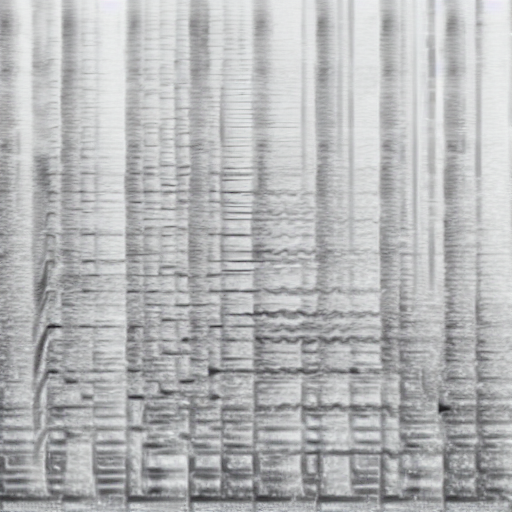

In [ ]:
#@title Here you can prompt the model to compose your song!
from PIL import Image

prompt = "church bells, opera singer female, high quality, well mastered, clear sound, harmonic"#@param {type:"string"}
negative_prompt = "noise, repetitive, looping"#@param {type:"string"}
music_style = "agile" #@param ["agile", "marim", "motorway", "og_beat", "vibes"] {allow-input: true}
denoising = 0.3 #@param {type:"slider", min:0, max:1, step:0.05}

seed_image = Image.open(f"./seed_images/{music_style}.png").convert("RGB")
# seed_image.thumbnail((768, 768))
seed_image.thumbnail((1001, 512))

path, spec = predict(prompt, negative_prompt, seed_image, denoising)

display(spec)
Audio('output.wav')

### Advanced Usage!

In the following you can take a snippet of any song of your choosing to use as a basis for the music generation.

In [ ]:
# @title This enables the downloading of songs on Youtube. 
%%capture

# !python3 -m pip install -U yt-dlp > /dev/null

# currently there is a bug with changed format of youtube channel names:
# https://github.com/yt-dlp/yt-dlp/issues/6247
# hack: 
#  * do not use pre-built python library with outdated code
#  * copy original repo and run using yt-dlp.sh script instead
!if [ ! -d yt-dlp ]; then git clone https://github.com/yt-dlp/yt-dlp.git > /dev/null; fi

import glob
import os
import shutil
import subprocess
from IPython import display as ipd

from google.colab import files

!mkdir -p audio

def convert_audio_to_mp3():
    for fp in glob.glob('audio/*'):
        if not fp.endswith('.mp3'):
            new_fp = os.path.splitext(fp)[0] + '.mp3'
            
            if not os.path.isfile(new_fp):                    
                try:
                    res = subprocess.run(
                        ['ffmpeg', '-i', fp, '-acodec', 'libmp3lame', new_fp], 
                        capture_output=True, check=True
                    )
                except subprocess.CalledProcessError as e:
                    print('subprocess call ended with non-zero exit code. '
                          f'stderr message:\n{e.stderr.decode()}')

            os.unlink(fp)  # remove original file

In [ ]:
%%capture

# @title Download any song on Youtube

youtube_video_link = "https://www.youtube.com/watch?v=c56t7upa8Bk" #@param {type:"string"}
convert_to_mp3 = True #@param {type:"boolean"}

assert len(youtube_video_link) > 0, ''

## run from cloned repo instead of using built python library.
# !yt-dlp -f bestaudio --extract-audio -o "%(title)s.%(ext)s" "{youtube_video_link}"
!yt-dlp/yt-dlp.sh -f bestaudio --extract-audio -o "audio/%(title)s.%(ext)s"  "{youtube_video_link}"

if convert_to_mp3 is True:
    convert_audio_to_mp3()

In [ ]:
#@title Now choose a 5 second snippet of your song to influence the music generation. The "file_name" is the title of the Youtube Vidoe. The time is measured in milliseconds in "start" and "end".

from pydub import AudioSegment

file_name = "Hans Zimmer - Time (Official Audio)" #@param {type:"string"}
file_format = "mp3" #@param {type:"string"}

sound = AudioSegment.from_file(f"/content/audio/{file_name}.{file_format}")

start = 15000 #@param {type:"number"}
end = 21000 #@param {type:"number"}

custom_sound = sound[start:end]
custom_sound

ORIGINAL AUDIO LENGTH IN MS: 6000
CROPPED AUDIO LENGTH IN MS: 5119


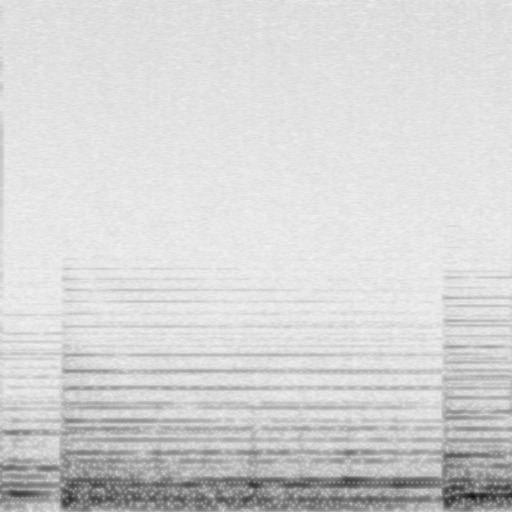

In [ ]:
#@title If you like the snippet, save the spectrogram to influence the music generation.

custom_sound_name = "epic" #@param {type:"string"}

import io

import numpy as np
from PIL import Image
import pydub
from scipy.io import wavfile
import torch
import torchaudio

nmels = 512
powerforimage = 0.25

def spectrogram_image_from_wav(wav_bytes: io.BytesIO, max_volume: float = 50, power_for_image: float = 0.25, ms_duration: int = 5119) -> Image.Image:
    """
    Generate a spectrogram image from a WAV file.
    """
    # Read WAV file from bytes
    sample_rate, waveform = wavfile.read(wav_bytes)

    #sample_rate = 44100  # [Hz]
    clip_duration_ms = ms_duration  # [ms]

    bins_per_image = 512
    n_mels = int(nmels)
    mel_scale = True

    # FFT parameters
    window_duration_ms = 100  # [ms]
    padded_duration_ms = 400  # [ms]
    step_size_ms = 10  # [ms]

    # Derived parameters
    num_samples = int(512 / float(bins_per_image) * clip_duration_ms) * sample_rate
    n_fft = int(padded_duration_ms / 1000.0 * sample_rate)
    hop_length = int(step_size_ms / 1000.0 * sample_rate)
    win_length = int(window_duration_ms / 1000.0 * sample_rate)

    # Compute spectrogram from waveform
    Sxx = spectrogram_from_waveform(
        waveform=waveform,
        sample_rate=sample_rate,
        n_fft=n_fft,
        hop_length=hop_length,
        win_length=win_length,
        mel_scale=mel_scale,
        n_mels=n_mels,
    )

    # Convert spectrogram to image
    image = image_from_spectrogram(Sxx, max_volume=max_volume, power_for_image=power_for_image)

    return image

def spectrogram_from_waveform(
    waveform: np.ndarray,
    sample_rate: int,
    n_fft: int,
    hop_length: int,
    win_length: int,
    mel_scale: bool = True,
    n_mels: int = 512,
) -> np.ndarray:
    """
    Compute a spectrogram from a waveform.
    """

    spectrogram_func = torchaudio.transforms.Spectrogram(
        n_fft=n_fft,
        power=None,
        hop_length=hop_length,
        win_length=win_length,
    )

    waveform_tensor = torch.from_numpy(waveform.astype(np.float32)).reshape(1, -1)
    Sxx_complex = spectrogram_func(waveform_tensor).numpy()[0]

    Sxx_mag = np.abs(Sxx_complex)

    if mel_scale:
        mel_scaler = torchaudio.transforms.MelScale(
            n_mels=n_mels,
            sample_rate=sample_rate,
            f_min=0,
            f_max=10000,
            n_stft=n_fft // 2 + 1,
            norm=None,
            mel_scale="htk",
        )

        Sxx_mag = mel_scaler(torch.from_numpy(Sxx_mag)).numpy()

    return Sxx_mag

def image_from_spectrogram(
        data: np.ndarray,
        max_volume: float = 50,
        power_for_image: float = 0.25
) -> Image.Image:
    data = np.power(data, power_for_image)
    data = data / (max_volume / 255)
    data = 255 - data
    data = data[::-1]
    image = Image.fromarray(data.astype(np.uint8))
    return image

def spectrogram_image_from_file(filename, max_volume: float = 50, power_for_image: float = 0.25) -> Image.Image:
    """
    Generate a spectrogram image from an MP3 file.
    """

    max_volume = int(max_volume)
    power_for_image = float(powerforimage)

    # Load MP3 file into AudioSegment object
    audio = pydub.AudioSegment.from_file(filename)

    # Convert to mono and set frame rate
    audio = audio.set_channels(1)
    audio = audio.set_frame_rate(44100)

    length_in_ms = len(audio)
    print("ORIGINAL AUDIO LENGTH IN MS:", length_in_ms)
    # Extract first 5 seconds of audio data
    audio = audio[:5119]
    length_in_ms = len(audio)
    print("CROPPED AUDIO LENGTH IN MS:", length_in_ms)

    # Convert to WAV and save as BytesIO object
    wav_bytes = io.BytesIO()
    audio.export("clip.wav", format="wav")
    audio.export(wav_bytes, format="wav")
    wav_bytes.seek(0)

    # Generate spectrogram image from WAV file
    return spectrogram_image_from_wav(wav_bytes, max_volume=max_volume, power_for_image=power_for_image, ms_duration=length_in_ms)

def convert(audio):
    
    image = spectrogram_image_from_file(audio, 50)

    return image

custom_sound.export(f"/content/{custom_sound_name}.mp3", format="mp3")

image = convert(f"/content/{custom_sound_name}.mp3")
image.save(f"seed_images/{custom_sound_name}.png")
display(image)

  0%|          | 0/60 [00:00<?, ?it/s]

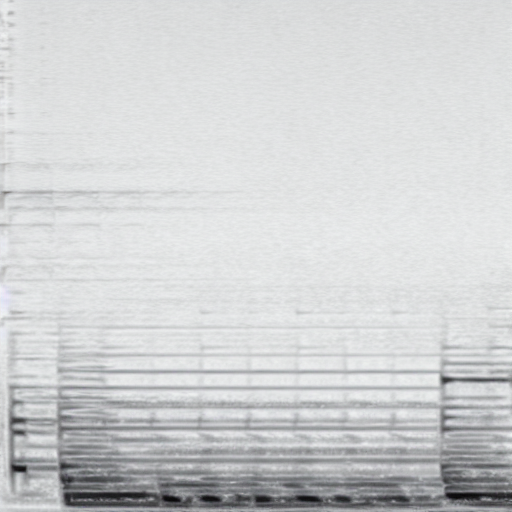

In [ ]:
#@title Use the generated sepctrogram to influence the music generation.
from PIL import Image

prompt = "epic, high quality, well mastered, clear sound, harmonic"#@param {type:"string"}
negative_prompt = "noise, repetitive, looping"#@param {type:"string"}
music_style = "epic" #@param ["agile", "marim", "motorway", "og_beat", "vibes"] {allow-input: true}
denoising = 0.6 #@param {type:"slider", min:0, max:1, step:0.05}

seed_image = Image.open(f"./seed_images/{music_style}.png").convert("RGB")
# seed_image.thumbnail((768, 768))
seed_image.thumbnail((512, 1024))

path, spec = predict(prompt, negative_prompt, seed_image, denoising)

display(spec)
Audio('output.wav')